In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import flax.linen as nn

from sklearn.datasets import make_moons
from rebayes_mini import callbacks
from functools import partial
from rebayes_mini.methods import recursive_vi_gauss as rvga

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")
palette = sns.color_palette()

In [7]:
palette = sns.color_palette()

In [65]:
n_samples = 500
n_samples = 1000
X, y = make_moons(n_samples, noise=0.15, random_state=314)

angle = jnp.pi * -0.3
R = jnp.array([
    [jnp.cos(angle), -jnp.sin(angle)],
    [jnp.sin(angle), jnp.cos(angle)]
])
X = jnp.einsum("mn,sn->sm", R, X)

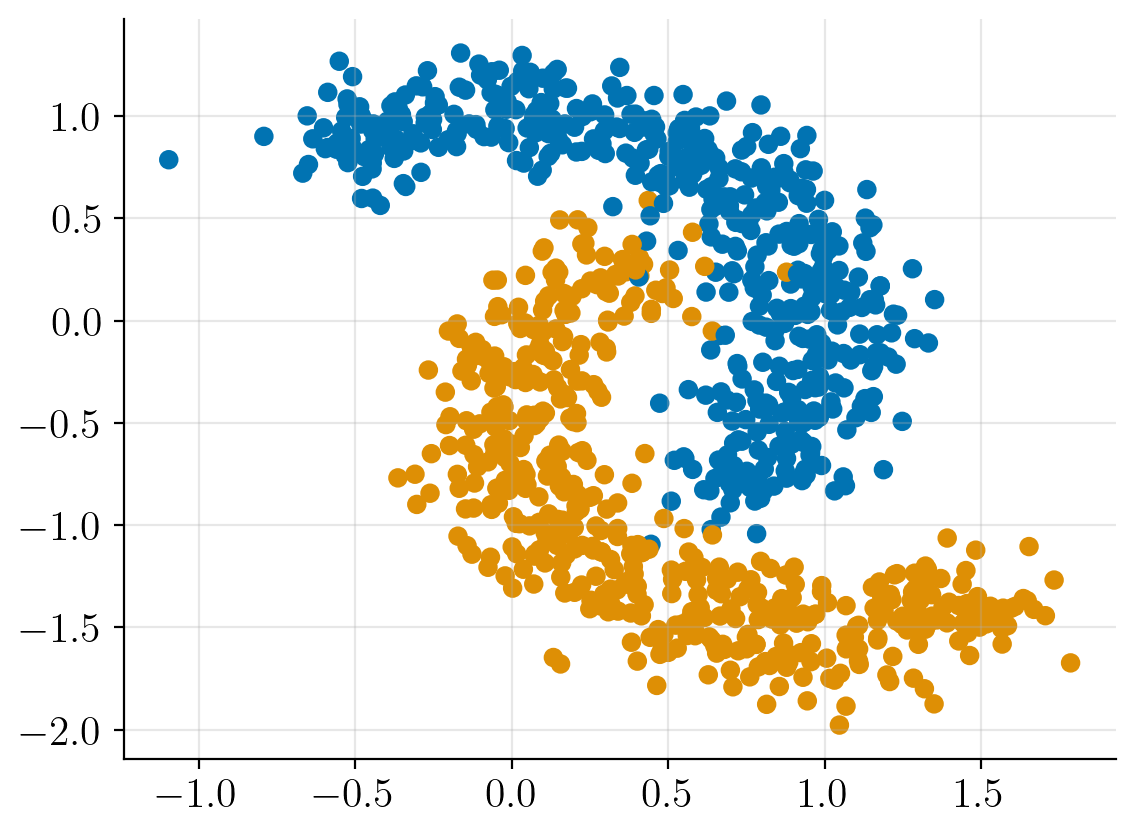

In [66]:
colors = [palette[v] for v in y]
plt.scatter(*X.T, c=colors)
plt.grid(alpha=0.3)

In [67]:
class MLP(nn.Module):
    def setup(self):
        self.activation = nn.leaky_relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = self.activation(x)
        x = nn.Dense(5)(x)
        x = self.activation(x)
        x = nn.Dense(5)(x)
        x = self.activation(x)
        x = nn.Dense(1)(x)
        # x = nn.sigmoid(x)
        return x

In [140]:
key = jax.random.PRNGKey(314)
key_init, key_run, key_sample = jax.random.split(key, 3)

In [141]:
mlp = MLP()
params_init = mlp.init(key_init, X)

In [193]:
rvga_filter = rvga.BernoulliRVGA(mlp.apply, n_inner=4, n_samples=1_000)
bel_init = rvga_filter.init_bel(params_init)

In [194]:
y = jnp.array(y)
bel_final, hist_bel = rvga_filter.scan(key_run, bel_init, y[:, None], X, callbacks.get_updated_bel)

In [195]:
%%time
preds = rvga_filter.mean(rvga_filter.link_fn(bel_final.mean, X).squeeze()).round()
(preds == y).mean().block_until_ready()

CPU times: user 161 ms, sys: 14.3 ms, total: 175 ms
Wall time: 4.38 s


Array(0.97400004, dtype=float32)

In [196]:
diag_terms =jnp.einsum("tii->ti", hist_bel.precision)

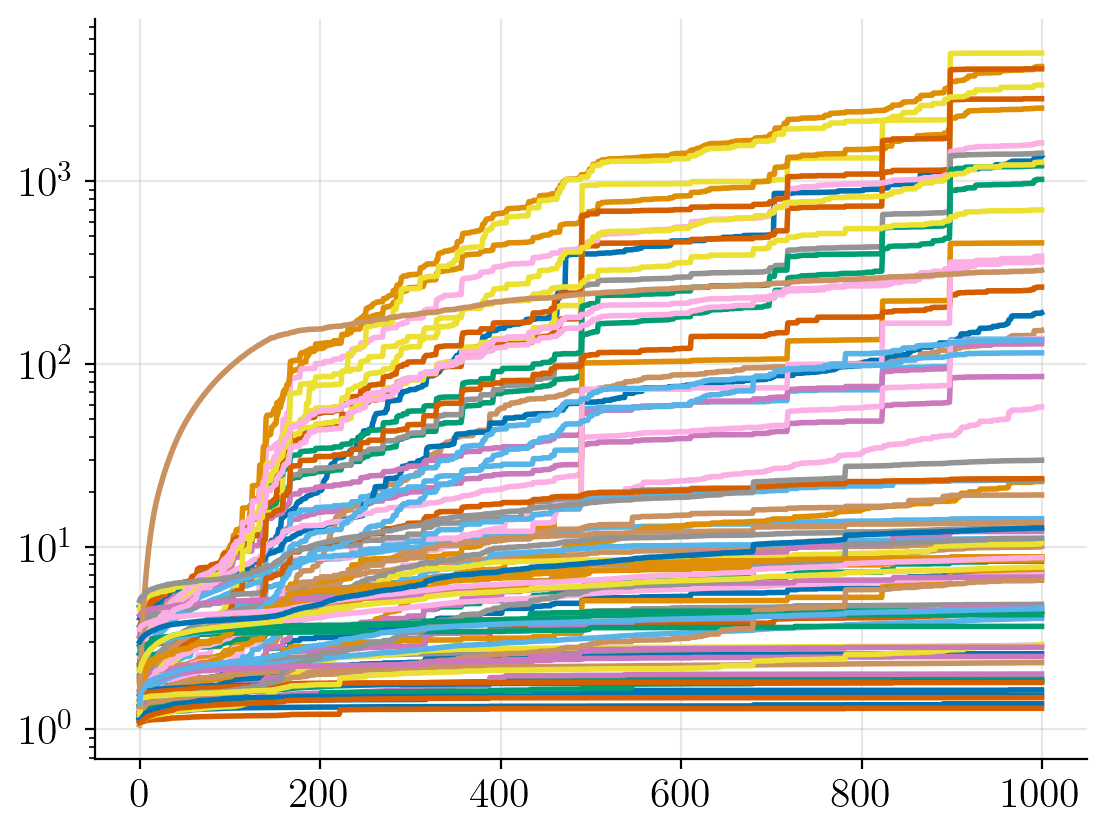

In [197]:
plt.plot(diag_terms)
plt.yscale("log")
plt.grid(alpha=0.3)

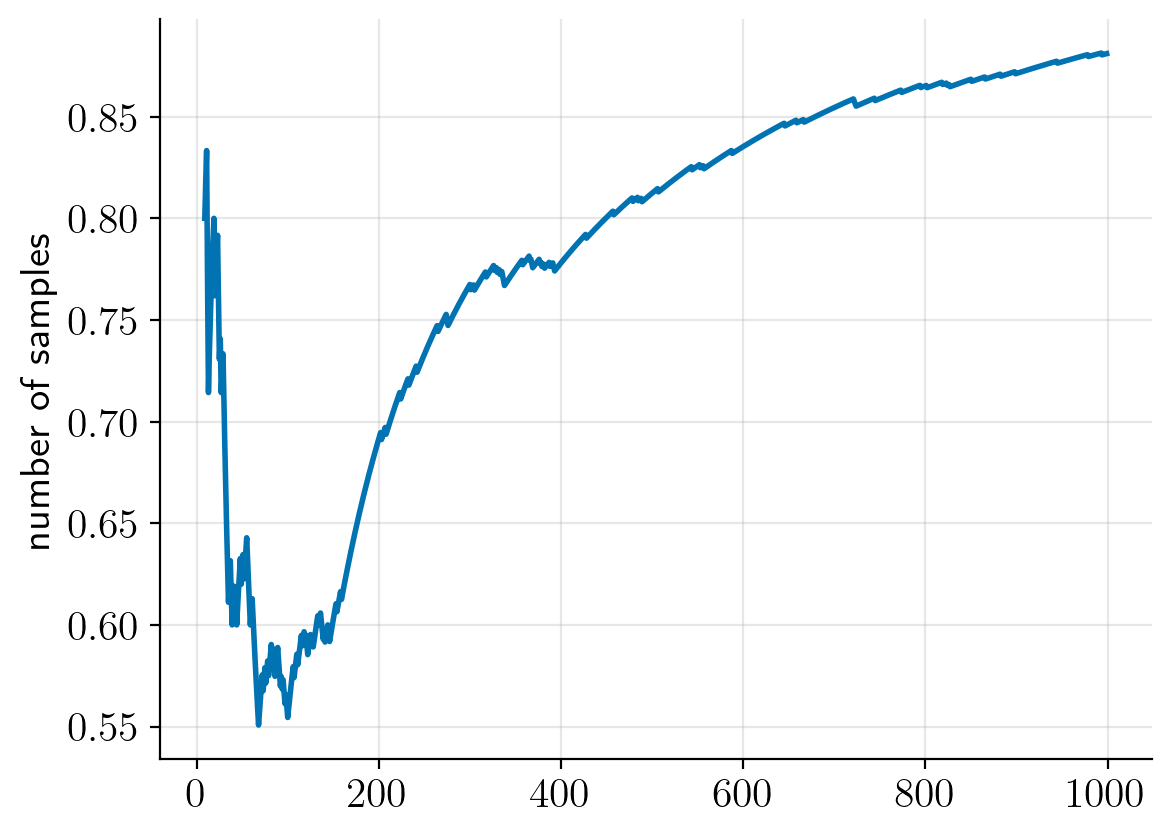

In [198]:
yhat = pred_step(hist_bel.mean, X)
pd.Series(yhat == y).expanding(10).mean().plot()
plt.ylabel("number of samples")
plt.grid(alpha=0.3)

In [158]:
vmin, vmax = -1.5, 1.5
x1 = jnp.linspace(vmin, vmax, 20)
x2 = jnp.linspace(vmin, vmax, 25)
Z = jnp.mgrid[vmin:vmax:20j,vmin:vmax:25j]
# Z = jnp.einsum("nm,mij->nij", R, Z)

In [159]:
@partial(jax.vmap, in_axes=(None, 2))
@partial(jax.vmap, in_axes=(None, 1))
def vpred(params, X):
    return rvga_filter.mean(rvga_filter.link_fn(params, X).squeeze())

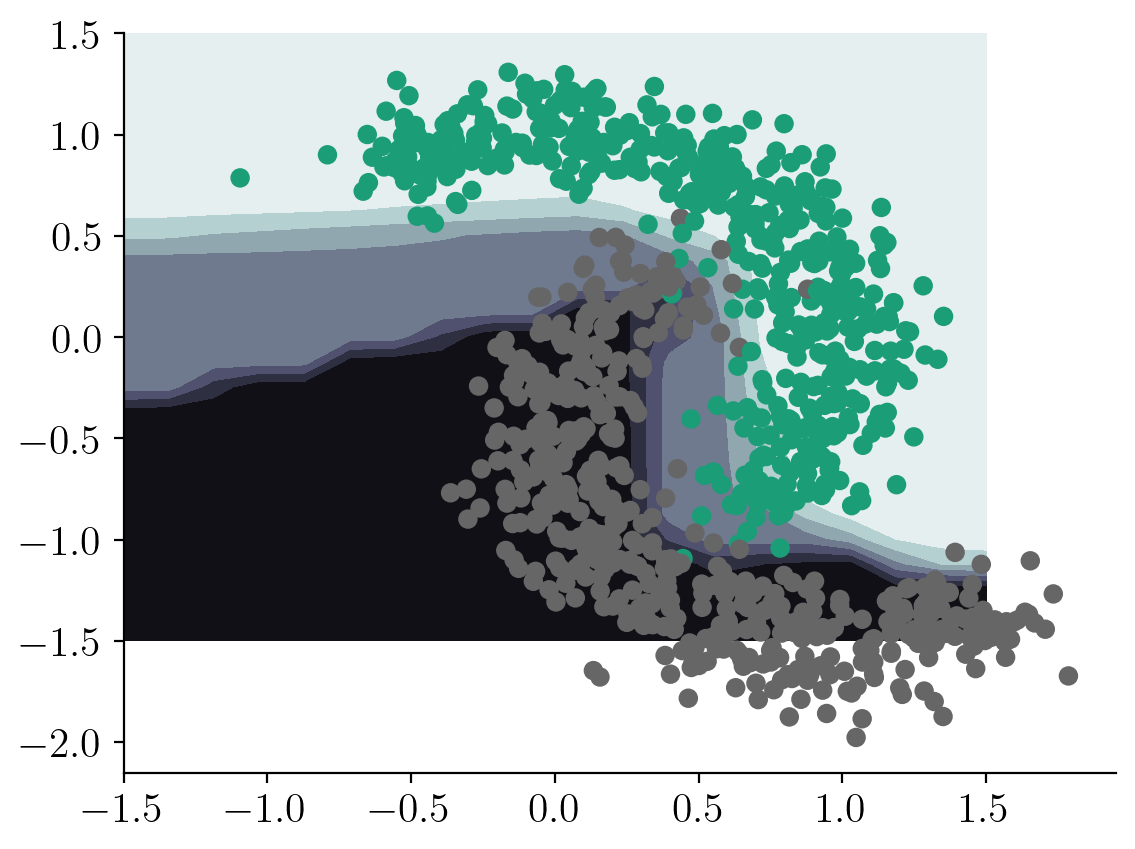

In [160]:
t = -1
S = vpred(hist_bel.mean[t], Z)
# S = vpred(bel_init.mean, Z)
plt.contourf(x1, x2, S, cmap="bone_r")
plt.scatter(*X[:t].T, c=y[:t], cmap="Dark2")

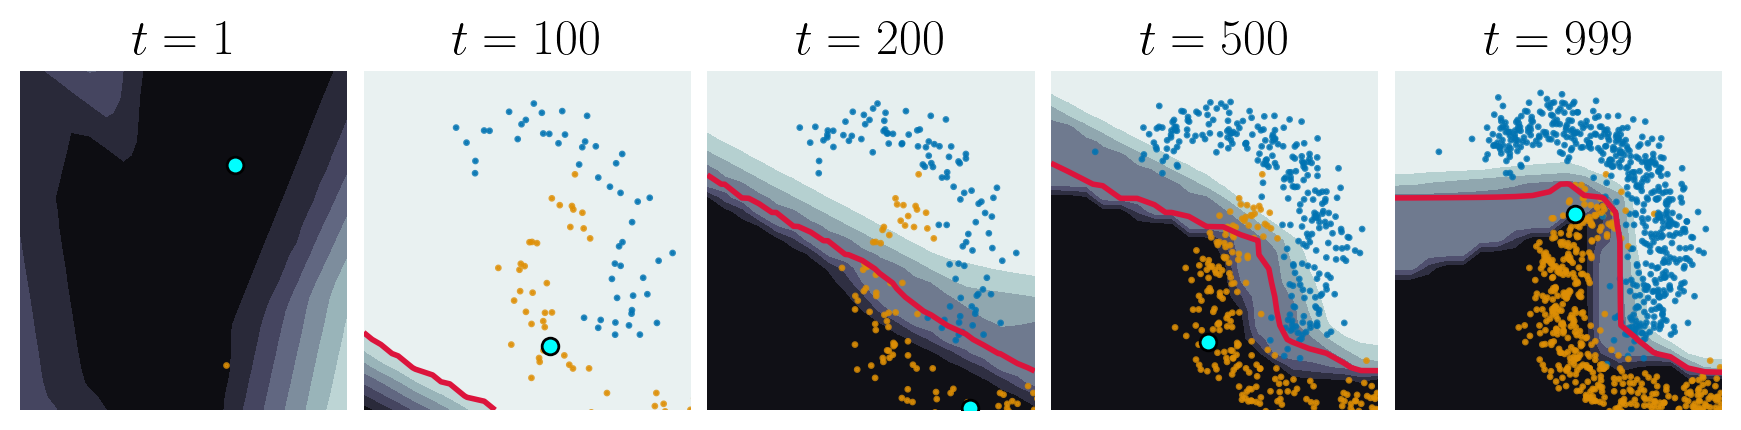

In [180]:
fig, axs = plt.subplots(1, 5, figsize=(6.4 * 1.4, 4.8 * 0.5), sharey=True, sharex=True)
t_values = [1, 100, 200, 500, 999]

for axi, t in zip(axs.ravel(), t_values):
    plt.sca(axi)
    bel_mean = hist_bel.mean[t]

    S = vpred(bel_mean, Z)
    
    plt.contourf(x1, x2, S, cmap="bone_r")

    colors = [palette[v] for v in y[:t]]
    plt.scatter(*X[:t].T, c=colors, s=2, alpha=0.8)
    plt.scatter(*X[t], c="cyan", marker="o", edgecolor="black")

    plt.contour(x1, x2, S, colors="crimson", levels=[0.5])
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    plt.grid(alpha=0.3)
    plt.title(f"$t={t}$")
    plt.sca(axi)
    plt.axis("off")


plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.0)
plt.savefig("../figures/recursive-nnet-cclf.png", dpi=300, bbox_inches="tight")